In [2]:
# default_exp tabular.tabnet_interpretation

# tabular.interpretation

> Useful interpretation functions for tabular, such as Feature Importance

In [3]:
#hide
from nbdev.showdoc import *

In [25]:
#export
from fastai.tabular.all import *
from scipy.cluster import hierarchy as hc
from sklearn import manifold

from fast_tabnet.core import *

In [5]:
#export
def base_error(err, val):
    try: return (err-val)/err
    except ZeroDivisionError: return np.nan

In [6]:
#export
@patch
def feature_importance(x:Learner, df=None, dl=None, perm_func=base_error, metric=accuracy, bs=None, reverse=True, plot=True):
    "Calculate and plot the Feature Importance based on `df`"
    x.df = df
    bs = bs if bs is not None else x.dls.bs
    if df is not None:
        dl = x.dls.test_dl(df, bs=bs)
    else:
        dl = x.dls[1]
    x_names = x.dls.x_names.filter(lambda x: '_na' not in x)
    na = x.dls.x_names.filter(lambda x: '_na' in x)
    y = x.dls.y_names
    orig_metrics = x.metrics
    x.metrics = [metric]    
    try:
        results = _calc_feat_importance(x, dl, x_names, na, perm_func, reverse)
        if plot:
            _plot_importance(_ord_dic_to_df(results))
    finally: # Restore original metrics
        x.metrics = orig_metrics
        
    return results

In [7]:
#export
def _measure_col(learn:Learner, dl:TabDataLoader, name:str, na:list):
    "Measures change after column permutation"
    col = [name]
    if f'{name}_na' in na: col.append(name)
    orig = dl.items[col].values
    perm = np.random.permutation(len(orig))
    dl.items[col] = dl.items[col].values[perm]
    with learn.no_bar(), learn.no_logging():
        metric = learn.validate(dl=dl)[1]
    dl.items[col] = orig
    return metric

In [8]:
#export
def _calc_feat_importance(learn:Learner, dl:TabDataLoader, x_names:list, na:list, perm_func=base_error, reverse=True):
    "Calculates permutation importance by shuffling a column by `perm_func`"
    with learn.no_bar(), learn.no_logging():
        base_error = learn.validate(dl=dl)[1]
    importance = {}
    pbar = progress_bar(x_names)
    print("Calculating Permutation Importance")
    for col in pbar:
        importance[col] = _measure_col(learn, dl, col, na)
    for key, value in importance.items():
        importance[key] = perm_func(base_error, value)
    return OrderedDict(sorted(importance.items(), key=lambda kv: kv[1], reverse=True))

In [9]:
#export
def _ord_dic_to_df(dict:OrderedDict): return pd.DataFrame([[k,v] for k,v in dict.items()], columns=['feature','importance'])

In [10]:
#export
def _plot_importance(df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [11]:
show_doc(Learner.feature_importance)

<h4 id="Learner.feature_importance" class="doc_header"><code>Learner.feature_importance</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.feature_importance</code>(**`x`**:`Learner`, **`df`**=*`None`*, **`dl`**=*`None`*, **`perm_func`**=*`'base_error'`*, **`metric`**=*`'accuracy'`*, **`bs`**=*`None`*, **`reverse`**=*`True`*, **`plot`**=*`True`*)

Calculate and plot the Feature Importance based on `df`

We can pass in sections of a `DataFrame`, but not a `DataLoader`. `perm_func` dictates how to calculate our importance, and `reverse` will determine how to sort the output

In [12]:
#export
def _get_top_corr(df, matrix, thresh:float=0.8):
    corr = np.where(abs(matrix) < thresh,0,matrix)
    idxs = []
    for i in range(corr.shape[0]):
        if (corr[i,:].sum() + corr[:, i].sum() > 2):
            idxs.append(i)
    cols = df.columns[idxs]
    return pd.DataFrame(corr[np.ix_(idxs,idxs)], columns=cols, index=cols)

In [13]:
#export
def _cramers_corrected_stat(cm):
    "Calculates Cramers V Statistic for categorical-categorical"
    try: chi2 = scipy.stats.chi2_contingency(cm)[0]
    except: return 0.0
    
    if chi2 == 0: return 0.0
    n = cm.sum().sum()
    phi2 = chi2 / n
    r,k = cm.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [14]:
#export
def _get_cramer_v_matr(dl:TabDataLoader):
    "Calculate Cramers V statistic on every pair in `df`'s columns'"
    df = dl.xs
    cols = list(df.columns)
    corrM = np.zeros((len(cols), len(cols)))
    for col1, col2 in progress_bar(list(itertools.combinations(cols, 2))):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1,idx2] = _cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
    np.fill_diagonal(corrM, 1.0)
    return corrM

In [15]:
#export
def _get_top_corr_dict_corrs(top_corrs):
    cols = top_corrs.columns
    top_corrs_np = top_corrs.to_numpy()
    corr_dict = {}
    for i in range(top_corrs_np.shape[0]):
        for j in range(i+1, top_corrs_np.shape[0]):
            if top_corrs_np[i,j] > 0:
                corr_dict[cols[i] + ' vs ' + cols[j]] = np.round(top_corrs_np[i,j],3)
    return OrderedDict(sorted(corr_dict.items(), key=lambda kv: abs(kv[1]), reverse=True))

In [16]:
#export
@patch
def get_top_corr_dict(x:Learner, df:pd.DataFrame, thresh:float=0.8):
    "Grabs top pairs of correlation with a given correlation matrix on `df` filtered by `thresh`"
    dl = x.dls.test_dl(df)
    matrix = _get_cramer_v_matr(dl)
    top_corrs = _get_top_corr(df, matrix, thresh=thresh)
    return _get_top_corr_dict_corrs(top_corrs)

In [17]:
show_doc(Learner.get_top_corr_dict)

<h4 id="Learner.get_top_corr_dict" class="doc_header"><code>Learner.get_top_corr_dict</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_top_corr_dict</code>(**`x`**:`Learner`, **`df`**:`DataFrame`, **`thresh`**:`float`=*`0.8`*)

Grabs top pairs of correlation with a given correlation matrix on `df` filtered by `thresh`

This along with `plot_dendrogram` and any helper functions along the way are based upon [this](https://github.com/Pak911/fastai-tabular-interpretation/blob/master/utils.py) by Pack911 on the fastai forums. 

In [18]:
#export
@patch
def plot_dendrogram(x:Learner, df:pd.DataFrame, figsize=None, leaf_font_size=16):
    "Plots dendrogram for a calculated correlation matrix"
    dl = x.dls.test_dl(df)
    matrix = _get_cramer_v_matr(dl)
    if figsize is None:
        figsize = (15, 0.02*leaf_font_size*len(dl.x_names))
    corr_condensed = hc.distance.squareform(1-matrix)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    dendrogram = hc.dendrogram(z, labels=dl.x_names, orientation='left', leaf_font_size = leaf_font_size)
    plt.show()

In [19]:
show_doc(Learner.plot_dendrogram)

<h4 id="Learner.plot_dendrogram" class="doc_header"><code>Learner.plot_dendrogram</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.plot_dendrogram</code>(**`x`**:`Learner`, **`df`**:`DataFrame`, **`figsize`**=*`None`*, **`leaf_font_size`**=*`16`*)

Plots dendrogram for a calculated correlation matrix

## Example Usage

We'll run an example on the `ADULT_SAMPLE` dataset

In [20]:
from fastai.tabular.all import *

In [21]:
path = untar_data(URLs.ADULT_SAMPLE)

In [22]:
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [31]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)
dls = to.dataloaders()

In [33]:
emb_szs = get_emb_sz(to)

In [ ]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=32, n_steps=1); 

In [34]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, opt_func=opt_func, metrics=[accuracy]).to_fp32()

In [35]:
learn.fit_one_cycle(2,lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.409465,0.489875,0.784705,00:24
1,0.389300,0.387379,0.828317,00:24


After fitting, let's first calculate the relative feature importance on the first 1,000 rows:

In [36]:
dl = learn.dls.test_dl(df)

Calculating Permutation Importance


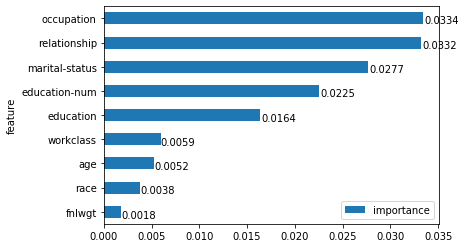

In [37]:
fi = learn.feature_importance(df=df)

Next we'll calculate the correlation matrix, and then we will plot it's dendrogram:

In [38]:
corr_dict = learn.get_top_corr_dict(df, thresh=0.3); corr_dict

OrderedDict([('workclass vs sex', 0.991),
             ('marital-status vs race', 0.506),
             ('education vs occupation', 0.493),
             ('fnlwgt vs education-num', 0.488),
             ('age vs education', 0.397),
             ('relationship vs race', 0.363),
             ('education-num vs race', 0.305)])

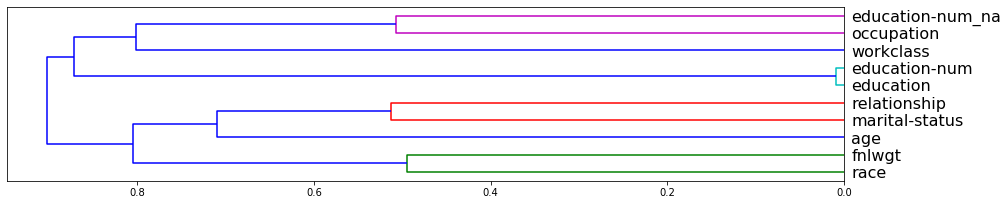

In [39]:
learn.plot_dendrogram(df)

This allows us to see what family of features are closesly related based on our `thresh`, and also to show (in combination with the feature importance) how our model uses each variable.

In [41]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_inference.ipynb.
Converted 00_soft_dependencies.ipynb.
Converted 00a_inference.text.ipynb.
Converted 00b_inference.export.ipynb.
Converted 01_tabular.core.ipynb.
Converted 01_tabular.interpretation.ipynb.
Converted 01_tabular.interpretation.tabnet.ipynb.
Converted 01_tabular.pd.ipynb.
Converted 01_tabular.waterfall.ipynb.
Converted 02_class_confusion.ipynb.
Converted 02_shap.core.ipynb.
Converted 02_shap.interp.ipynb.
Converted 03_onnx.ipynb.
Converted index.ipynb.
